# this code is analysis of experiment using code built with positive control data
[I used simulation data for two systems. In both the Smad pathway is simulated identically, with random noise in parameters and protein expression. The differene in the two systems is that in system 1, [gene = f(Smad3/4)], target gene expression depends directly on nuclear Smad3/Smad4, and in system 2, [gene = f(Smad3/4 , X)] target gene expression depends on nuclear Smad3/Smad4 and a randomly varying other factor, X (which in this case is a factor that affects how strongly Smad3/4 induces gene expression.]

From the simulated data, I use full trajectories for the level nuclear Smad3--that is the concentration of all species of Smad3 in the nucleus, such as would be observed in a microscope. (Note, I am not using trajectories for Smad3/Smad4 complex, which is the actual molecular complex on which gene production depends. I do not use these trajectories because they are not measurable in cells). Second, I use full trajectories of target gene production. For gene expression I analyze either A) a gene whose production depends directly on Smad3/Smad4 binding, or B) a gene whose production depends on a small network motif (3-nodes total, I-FFL1 specifically) that causes production of gene to be proportional to the fold-change in Smad3/Smad4 complex.

For experimental""" analysis, I take trajectories of nuclear NG-Smad3, which were measured in single cells from experiments and I take trajectories of total nuclear Snail:mCherry (or median, see next experiment). I first run diffusion maps on the NG-Smad3 trajectories to obtain a good DMAP for NG-Smad3. Then I obtain a DMAP for Snail using the same method. Then I use Gaussian Process Regression to assess whether Snail dynamics (i.e. Snail DMAP) can be predicted using Smad3 dynamics (i.e. Snail DMAP). 

In order to obtain a good diffusion map, I prepare (process?) the original data in the following way.
1. First, I take raw data as is. This is matrix1. (Matrix1 is M cells X N timepoints)
2. Then I take the raw data and compute the derivative of each trajectory. This is matrix 2. 
3. Then I take the raw data and compute the integral of each trajectory. This is matrix 3. 
4. Then I combine matrices 1, 2 and 3 into one new matrix, MatrixCAT (MatrixCAT is M cells X 3*N timepoints)
5. Then I transform this data set (in a way the preserves the topology of the data set) by normalizing all trajectories at each time point using the following:
    MT = MatrixCAT[t,:] (t=1)
    [MT is an 1 x M array, where M is the number of cells]
    MTn = MT-min(MT)/(max(MT)-min(MT)
    MTns = sqrt(MTn)
    MatrixCATztos[t,:] = MTns
    [I do this for all timepoints]
6. This transformation preserves topology, and it ensures that the difussion distances are similar for each dimension, which is important for finding a good difussion kernel for the diffusion map algoritm. 
7. By including raw data, first derivative of data, and integral of data were are enableing the algorithm to find a difussion Map that uncovers the dynamical features of the data set. 





# below this is the one value you must change if you change how this code runs

In [1]:
#epscale paramters
#num_evecs
#peakfindercutoff

#epsilon search parameters
num_eps = 50
eL = 1.2
eH = 4

evecs_cut = True
num_evecs=30

sampiter = 20 #number of times to iterate through Local linear regression
subsampfactor = 8 #scale at which to subsample data for LLR # subsampsize = np.ceil(datasize/subsampfactor)
subsampmax = 500 # never run LLR for more than 500 data pts; it will fail

reducedimval = 50
promval = 0.05 #defines prominence of peaks at which to threshold

In [2]:
# specid = 'EXP_S3conc_SNAILconc_gpy_LLRpeakfinder-AGNOSTIC-ztosqrtResample'
specid = 'agnostic-AGI-zto_numeps'+str(num_eps)+'-'+str(eL)+'-'+str(eH)+'_rdimval'+str(reducedimval)+'_n-evecs'+str(num_evecs)+'cut-'+str(evecs_cut)+'_promval-'+str(promval)+'_SI-'+str(sampiter)+'_subsampF'+str(subsampfactor)+'_sampmax'+str(subsampmax)  
print(specid)

agnostic-AGI-zto_numeps50-1.2-4_rdimval50_n-evecs30cut-True_promval-0.05_SI-20_subsampF8_sampmax500


/Users/frick/Dparams/DParamsFinal_v5
4  runs to perform
using ogdata1 = ogdin
csvsub1 exp5-SMAD-median
ev_in =  [1, 3, 7]
[1, 3, 7]


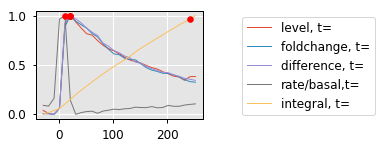

0
1
2
3
4
5
6


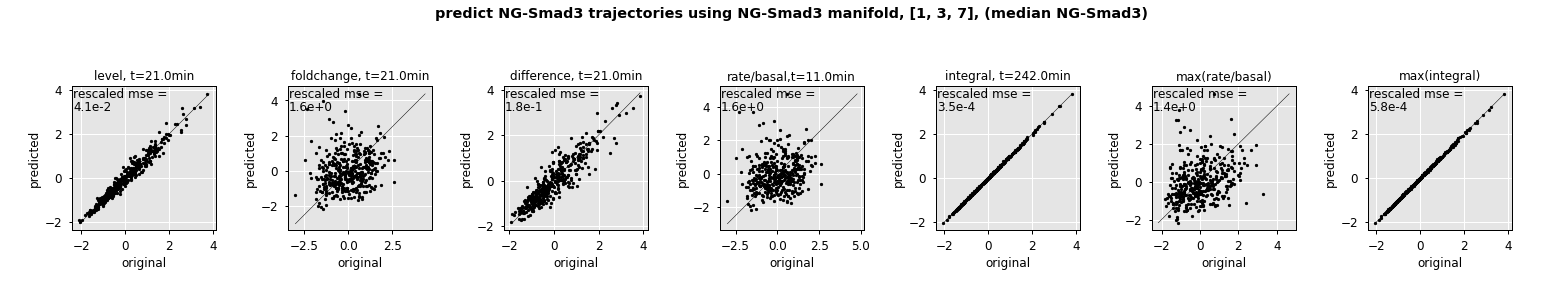

using ogdata1 = ogdin
csvsub1 exp5-SMAD-total
ev_in =  [1, 4, 13]
[1, 4, 13]


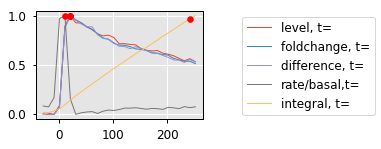

0
1
2
3
4
5
6


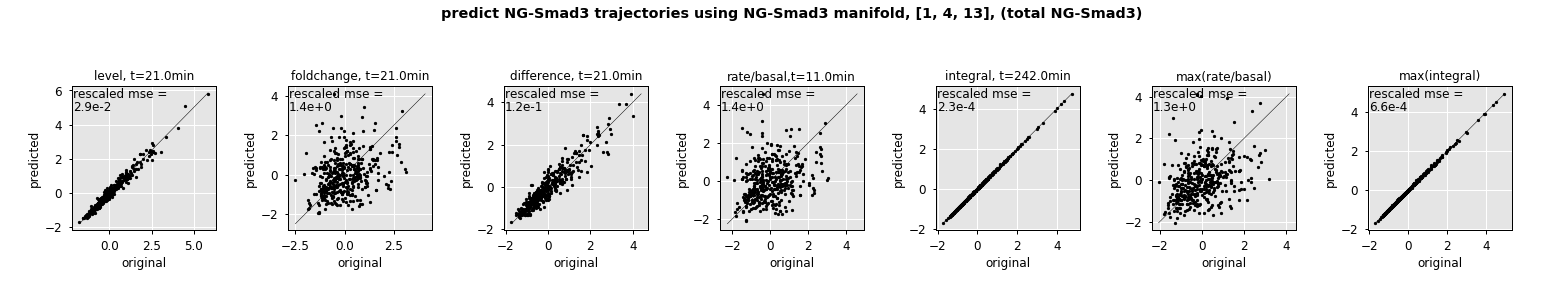

using ogdata1 = ogdout
csvsub1 exp5-GENE-median
ev_in =  [1, 3]
[1, 3]


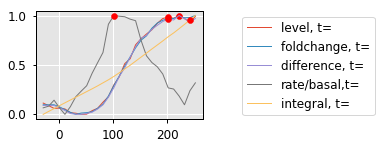

0
1
2
3
4
5
6


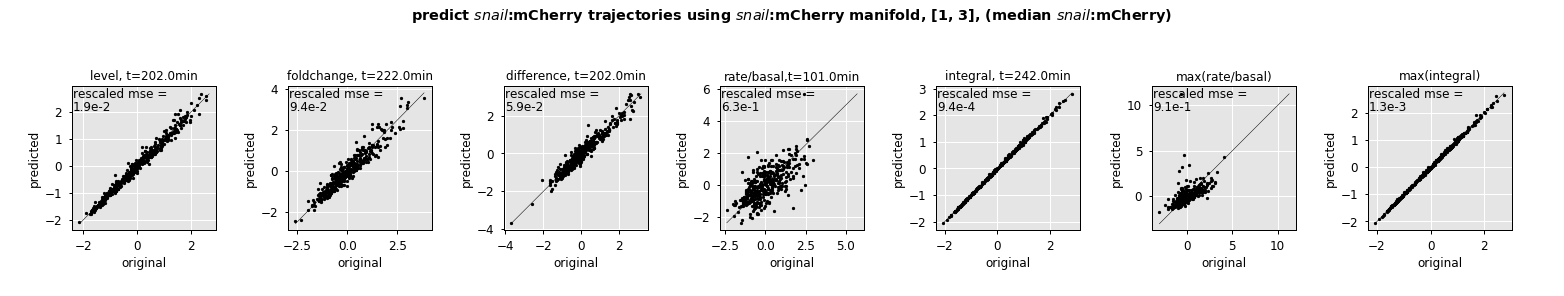

using ogdata1 = ogdout
csvsub1 exp5-GENE-total
ev_in =  [1, 6]
[1, 6]


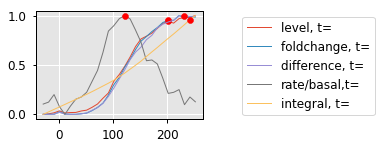

0
1
2
3
4
5
6


 /Users/frick/anaconda/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/frick/anaconda/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/frick/anaconda/lib/python3.6/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:invalid value encountered in multiply


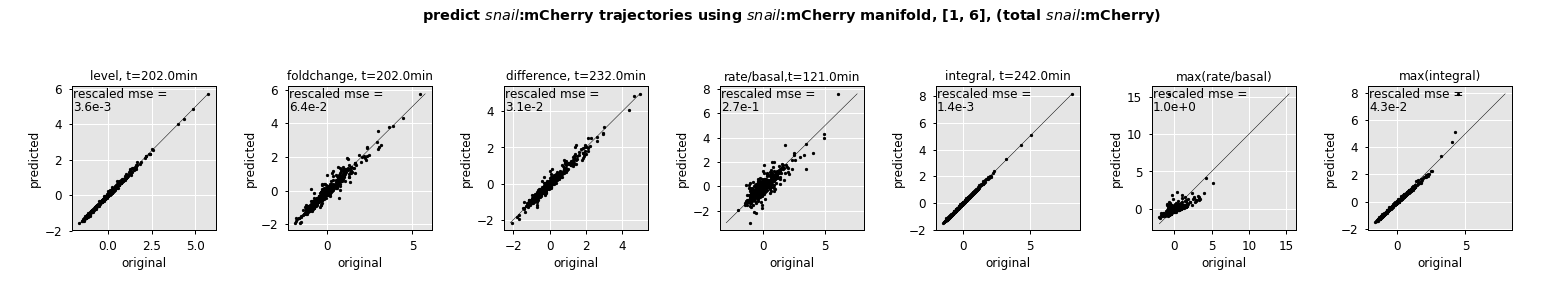

In [3]:
from pathlib import Path
cwd = Path().resolve()
print(cwd)
import sys
sys.path.insert(0, cwd) 


import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as manimation
import numpy as np

import matplotlib.tri as mtri

from scipy.integrate import odeint
from scipy.integrate import complex_ode

import scipy.spatial.distance
import scipy
import scipy.interpolate
import scipy.signal
import itertools 
import re

from dmap_sp_chrisNEW import *
import os

import dmap_sp_chrisNEW
import importlib
importlib.reload(dmap_sp_chrisNEW)
    
from accessory import *


specidpath = specid.replace(".", "dot")

repo = str(cwd) +'/'

# ########################  IMPORT   ############################
import dill as pickle;
#     from pathlib import Path



session_savepath =  specidpath + '/'
session_path = repo + session_savepath

#     print(not (os.path.isdir(session_path)))
if not (os.path.isdir(session_path)):
    print('making' + session_path + '...')
    error('incoddrect directory')




filenames = list()
for file in os.listdir(session_path):
    if file.endswith("pickle"):
        if bool(re.search('SMAD-rsmad',file)):
            filenames = filenames + list([file])
#             print(os.path.join(session_path,file))
#             filenames = filenames + list(str((os.path.join(session_path,file))))




a = ['exp5']
b = ['SMAD-median','SMAD-total']
c = ['GENE-median','GENE-total']
expSMAD = list(itertools.product(a,b))
expSNAIL = list(itertools.product(a,c))

a1 = ['exp']
b = ['SMAD-rsmad','SMAD-complex']
simSMAD = list(itertools.product(a1,b))

a2 = ['expSYST1_PC','expSYST2_PC','expSYST3_PC']
c = ['GENE-iffl','GENE-caga']
simGENE = list(itertools.product(a2,c))




a1 = ['exp']
b = ['SMAD-rsmad']
simSMADpos = list(itertools.product(a1,b))

a2 = ['expSYST1_PC','expSYST2_PC']
c = ['GENE-iffl']
simGENEpos = list(itertools.product(a2,c))
# dall = simSMADpos + simGENEpos




a = ['exp5']
b = ['SMAD-median','SMAD-total']
c = ['GENE-median','GENE-total']
expSMAD = list(itertools.product(a,b))
expSNAIL = list(itertools.product(a,c))

dall = expSMAD + expSNAIL
print(len(dall), ' runs to perform')
for dd in dall:

############ this block of loads best manifold ########################  


#     checkstr1 = 'exp'
#     checkstr2 = 'SMAD-rsmad'
    checkstr1 = dd[0]
    checkstr2 = dd[1]
    filenames = list()
    for file in os.listdir(session_path):
        if file.endswith("pickle"):
            if (bool(re.search(checkstr1,file)) & (bool(re.search(checkstr2,file)))):
                filenames = filenames + list([file])   
#             if ((bool(re.search(checkstr1,file)) & (bool(re.search(checkstr2,file)))) & (bool(re.search('SYST1_PC',file)))):
#                 filenames = filenames + list([file])   
#                 print ('REMOVE THIS CODEEEEEE!!!!!!!!!!!')
#                 print ('REMOVE THIS CODEEEEEE!!!!!!!!!!!')                                                                          
#                 print ('REMOVE THIS CODEEEEEE!!!!!!!!!!!')
  

    file = filenames[0]
    pickle.load_session(session_path + file)


        
    if bool(re.search('GENE',checkstr2)):
        epsfact = epsfactout
        ogdata1 = ogdout
        print('using ogdata1 = ogdout')
    else:
        epsfact = epsfactin
        ogdata1 = ogdin
        print('using ogdata1 = ogdin')
        
        
    bestdmapcsv_savepath1 = str(cwd) + '/' + specidpath + '/' 
    if not os.path.exists(bestdmapcsv_savepath1):
        error('no dir')   
    bestdmapcsv_savepath2 = bestdmapcsv_savepath1 + 'csvfiles'+'/'
    if not os.path.exists(bestdmapcsv_savepath2):
        error('no dir')
        
        

    # #load the CSV files    
    csvsub1 = checkstr1 + '-' + checkstr2
    savepath  = bestdmapcsv_savepath2 + csvsub1  + '-'

    evecs_in_csv = np.genfromtxt(savepath+"evecs_in.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")
    evals_in_csv = np.genfromtxt(savepath+"evals_in.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")
    eps_in_csv = np.genfromtxt(savepath+"eps_in.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")
    ev_in_csv = np.genfromtxt(savepath+"ev_in.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")

    evecs_in = evecs_in_csv
    evals_in = evals_in_csv
    eps_in = eps_in_csv
    ev_in = [int(x) for x in ev_in_csv]
    print('csvsub1',csvsub1)
    print('ev_in = ', ev_in)
    
    
    ############### DO ALL SELF PLOTTING HERE #######################
    #################################################################    
           
    stylestr = 'FrickNEW3'
    plt.style.use(stylestr)
    cmapstr = 'viridis'
    cmap = plt.get_cmap(cmapstr)


    savepath = str(cwd) + '/' + specidpath + '/2d-manifolds colored by other-'+cmapstr+'-'+stylestr+'/'
    if not os.path.exists(savepath):
        os.mkdir(savepath)
        print('making...', savepath)

    fsize=np.asarray([4.4,3])/1.3
    msize = 50
    lw=2
    fontsize = 12

    import GPy_helper
    from GPy_helper import *
    import importlib
    importlib.reload(GPy_helper)
    print(ev_in)

    ss10 = checkstr1+'-'+checkstr2

    ss1,ss1sub = catchImportantWords(ss10)
    ss20=''
    ss2=''
    ss2sub=''

    stylestr = 'FrickNEW3'
    plt.style.use(stylestr)
    cmapstr = 'viridis'
    cmap = plt.get_cmap(cmapstr)


    savepath = str(cwd) + '/' + specidpath + '/GPY-self-predictions_'+stylestr+'/'
    if not os.path.exists(savepath):
        os.mkdir(savepath)
        print('making...', savepath)

    fsize=np.asarray([4.4,3])/1.3
    msize = 50
    lw=2
    fontsize = 12

    #predictions based on data1
    X = evecs_in[:,ev_in].copy()
    X0=X.copy()
    sdat1 = ogdata1.copy()
    msekeepersmad = predictSELF_BasedOnDMAP(time_data,ss10,X0,sdat1,ev_in,savepath,fontsize)
    

In [ ]:
    ############################### NOW LOAD COMPLIMENTARY DATA AND EVECS FOR INPUT OUTPUT PREDICTIONS

    #now determine all possible complimentary evecs
    checkstr1 = dd[0]
    checkstr2 = dd[1]
    checkstrcomboA = checkstr1+'-'+checkstr2
    if (bool(re.search('rsmad',checkstr2)) | bool(re.search('complex',checkstr2))):
        checkstr1 = 'exp'


    filenames = list()
    for file in os.listdir(session_path):
        if file.endswith("pickle"):
            if (bool(re.search(checkstr1,file)) & (bool(re.search(checkstr2,file)))):
                filenames = filenames + list([file])   

    outfilesToLoad = list()
    for x in filenames: 
        if bool(re.search('SMAD',checkstrcomboA)):
            m = re.search(r'\w+(?=pickle)',x)
            m.group(0)
            checkstr4 = 'GENE-' + str(m.group(0))
        else:
            m = re.search(r'(?<=SMAD-)\w+',x)
            mstr = str(m.group(0))
            m = re.search(r'\w+(?=_)',mstr)
            checkstr4 = 'SMAD-' +str(m.group(0))

        m = re.search(r'\w+(?=_SMAD)',x)
        mstr = str(m.group(0))
        m = re.search(r'(?<=epssearch)\w+',mstr)
        checkstr3 = str(m.group(0))

        if (bool(re.search('rsmad',checkstr4)) | bool(re.search('complex',checkstr4))):
            checkstr3 = 'exp'

        checkstrcomboB = checkstr3+'-'+checkstr4
    #     outfilesToLoad = outfilesToLoad+checkstrcomboB
        outfilesToLoad = outfilesToLoad+list([(checkstr3,checkstr4)])




    #now you can use this to make plots where you color the original manifold with the newly loaded manifold    
    for ddx in outfilesToLoad:
        print(ddx)
        checkstr3 = ddx[0]
        checkstr4 = ddx[1]
        
        
        filenames2 = list()
        for file in os.listdir(session_path):
            if file.endswith("pickle"):
                if (bool(re.search(checkstr3,file)) & (bool(re.search(checkstr4,file)))):
                    filenames2 = filenames2 + list([file])   

                    
        file = filenames2[0]
        pickle.load_session(session_path + file)

        if bool(re.search(checkstr4,'GENE')):
            epsfact = epsfactout
            ogdata2 = ogdout
        else:
            epsfact = epsfactin
            ogdata2 = ogdin


        csvsub2 = checkstr3 + '-' + checkstr4

        savepath  = bestdmapcsv_savepath2 + csvsub2  + '-'

        evecs_out_csv = np.genfromtxt(savepath+"evecs_in.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")
        evals_out_csv = np.genfromtxt(savepath+"evals_in.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")
        eps_out_csv = np.genfromtxt(savepath+"eps_in.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")
        ev_out_csv = np.genfromtxt(savepath+"ev_in.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")

        evecs_out = evecs_out_csv
        evals_out = evals_out_csv
        eps_out = eps_out_csv
        ev_out = [int(x) for x in ev_out_csv]
        print('csvsub= 2 ',csvsub2)
        print('ev_out = ', ev_out)





        

            

 

In [34]:
        
        def Gpy_eachtpoint(X,Yin0,samp_vec,messages,max_f_eval,inputstr,outputstr):
            Yin = Yin0[:,samp_vec]
            msearray = np.zeros(Yin.shape[1])
            for j in range(0,Yin.shape[1]):
                Y = Yin[:,j].reshape(-1,1)

                max_f_eval = 1000
                messages=False
                m = Gpymadness(X,Y,messages,max_f_eval,inputstr,outputstr)

                xp,xstd = m.predict(X)
                x = Y
                y = xp
                x1,y1, mse, mseeach = msefunc(xp,Y)
                msearray[j]=mse
                print(j, end=" " )
            print('completed' + inputstr + outputstr)
            return msearray


        def make_samp_vec(Yin,tsamp):
            ltv = Yin.shape[1]
            ax1 = np.ceil(ltv/2) - np.ceil(ltv/5)
            ax2 = np.ceil(ltv/2) + np.ceil(ltv/5)
            samp_vec = np.linspace(ax1,ax2,tsamp,dtype='int32')
            return samp_vec

        def gpy_each_timepoint(inputstr,X,fsmad,fsmadpro,snaildat,ss1,ss2):
            #attempt to predict input data at all timepoints using Smad Dmaps
            msecombo={} #initialize the master msecombo
            max_f_eval = 1000
            messages = False
            tsamp=4

            ## run each
            outputstr = ss1 + ' at each tpoint'
            Yin = fsmad
            samp_vec = make_samp_vec(Yin,tsamp)
            msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
            msecombo[outputstr] = msearray


            outputstr = ss2 + ' at each tpoint'
            Yin = snaildat
            samp_vec = make_samp_vec(Yin,tsamp)
            msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
            msecombo[outputstr] = msearray


            outputstr = 'f('+ss1+')'
            Z = fsmad.copy()
            mu, sigma = 0, 0.0 # mean and standard deviation
            for j in range(0,fsmad.shape[1]):
                s = np.random.normal(mu, sigma, fsmad.shape[0])
                Z[:,j] = (fsmad[:,j]**2) + s

            Yin = removeAllzerotpoints(Z.copy())
            samp_vec = make_samp_vec(Yin,tsamp)
            msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
            msecombo[outputstr] = msearray


            outputstr = 'f('+ss1+')+smallnoise'
            Z = fsmad.copy()
            mu, sigma = 0, 0.01 # mean and standard deviation
            for j in range(0,fsmad.shape[1]):
                s = np.random.normal(mu, sigma, fsmad.shape[0])
            #     s = np.random.lognormal(mean, sigma, size=fsmad.shape[0])
                Z[:,j] = (fsmad[:,j]**2) + s

            Yin = removeAllzerotpoints(Z.copy())
            samp_vec = make_samp_vec(Yin,tsamp)
            msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
            msecombo[outputstr] = msearray


            outputstr = 'f('+ss1+')+mediumnoise'
            Z = fsmad.copy()
            mu, sigma = 0, 0.1 # mean and standard deviation
            for j in range(0,fsmad.shape[1]):
                s = np.random.normal(mu, sigma, fsmad.shape[0])
                Z[:,j] = (fsmad[:,j]**2) + s

            Yin = removeAllzerotpoints(Z.copy())
            samp_vec = make_samp_vec(Yin,tsamp)
            msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
            msecombo[outputstr] = msearray


            outputstr = 'f('+ss1+'_processed)'
            Z = fsmadpro.copy()
            mu, sigma = 0, 0.0 # mean and standard deviation
            for j in range(0,fsmadpro.shape[1]):
                s = np.random.normal(mu, sigma, fsmadpro.shape[0])
                Z[:,j] = (fsmadpro[:,j]**2) + s

            Yin = removeAllzerotpoints(Z.copy())
            samp_vec = make_samp_vec(Yin,tsamp)
            msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
            msecombo[outputstr] = msearray

            outputstr = 'f('+ss1+'_processed)+s_noise'
            Z = fsmadpro.copy()
            mu, sigma = 0, 0.01 # mean and standard deviation
            for j in range(0,fsmadpro.shape[1]):
                s = np.random.normal(mu, sigma, fsmadpro.shape[0])
                Z[:,j] = (fsmadpro[:,j]**2) + s

            Yin = removeAllzerotpoints(Z.copy())
            samp_vec = make_samp_vec(Yin,tsamp)
            msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
            msecombo[outputstr] = msearray

            outputstr = 'f('+ss1+'_processed)+m_noise'
            Z = fsmadpro.copy()
            mu, sigma = 0, 0.1 # mean and standard deviation
            for j in range(0,fsmadpro.shape[1]):
                s = np.random.normal(mu, sigma, fsmadpro.shape[0])
                Z[:,j] = (fsmadpro[:,j]**2) + s


            Yin = removeAllzerotpoints(Z.copy())
            samp_vec = make_samp_vec(Yin,tsamp)
            msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
            msecombo[outputstr] = msearray


            outputstr = 'noise only'
            Z = fsmad.copy()
            samp_vec = make_samp_vec(Yin,tsamp)
            mu, sigma = 0, 1 # mean and standard deviation
            for j in range(0,fsmad.shape[1]):
                s = np.random.normal(mu, sigma, fsmad.shape[0])
                Z[:,j] = s

            Yin = Z
            msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
            msecombo[outputstr] = msearray
            return msecombo

        # msecombosmad = msecombo.copy()

        inputstr = ss1 + ' dmap'
        X = evecs_in[:,ev_in].copy()
        fsmad = reducedimensionalityforGPy(ogdata1.copy(),reducedimval)
        fsmadpro = reducedimensionalityforGPy(observed_data_in.copy(),reducedimval)
        snaildat = reducedimensionalityforGPy(ogdata2.copy(),reducedimval)
        ss1 = ss1sub
        ss2 = ss2sub
        msecombosmad = gpy_each_timepoint(inputstr,X,fsmad,fsmadpro,snaildat,ss1,ss2)


        inputstr = ss2 + ' dmap'
        X = evecs_out[:,ev_in].copy()
        fsmad = reducedimensionalityforGPy(ogdata2.copy(),reducedimval)
        fsmadpro = reducedimensionalityforGPy(observed_data_out.copy(),reducedimval)
        snaildat = reducedimensionalityforGPy(ogdata1.copy(),reducedimval)

        ss1 = ss2sub
        ss2 = ss1sub
        msecombosnail = gpy_each_timepoint(inputstr,X,fsmad,fsmadpro,snaildat,ss1,ss2)

        def msecomboplotter(tvec,msecombo,smadsnail,yl):
            plt.figure(figsize=(5,3))
            subkeep={}
            cycle=0
            for k in msecombo.keys():
                cycle=cycle+1
                v = msecombo[k]
              # k is now the key
              # v is the value
                subkeep[k]=v
                plt.semilogy(tvec+(cycle/100),v,'*-', label=k)

            plt.ylim(yl[0],yl[1])
            plt.ylabel('mean square error')
            plt.xlabel('time point, value')
            plt.title('error for different predictions based on '+ smadsnail + ' manifold') 
            plt.legend()
            plt.legend(loc='right',bbox_to_anchor=(1.8, 0.5))
            plt.show()

        def msecombomedianplotter(msecombo,smadsnail):
            plt.figure(figsize=(6,3))
            msecombo2 = msecombo.copy()
            cycle=-1
            for k in msecombo.keys():
                y={}
                cycle=cycle+1
                v = msecombo[k]
                y[cycle] = np.median(v)
                msecombo2[k] = y

            cycle=-1
            for k in msecombo2.keys():
                cycle=cycle+1
                v = msecombo2[k]
              # k is now the key
              # v is the value
                y = v.values()
                if len(y)==1:
                    x = cycle
                    markerstr='o'
                else:
                    x = np.linspace(cycle-0.1,cycle+0.1,len(y))
                    markerstr='*-'
                plt.semilogy(x,y,markerstr, label=k)

                    # plt.ylim(0.01,1)
            plt.ylabel('mean square error')
            plt.xlabel('attempted prediction')
            plt.title('error for different predictions based on ' + smadsnail + ' manifold') 
            plt.legend(loc='right',bbox_to_anchor=(1.5, 0.5))
            plt.show()


        def msekeeperplotter(msekeeper2,yl,smadsnail):  
            cycle=-1
            plt.figure(figsize=(4,2))
            for k in msekeeper2.keys():
                cycle=cycle+1
                v = msekeeper2[k]
              # k is now the key
              # v is the value
                y = np.asarray(list(v.values())).reshape(-1,)
                if len(y)==1:
                    x = cycle
                    markerstr='o'
                    msize = 7
                    if y<yl[0]:
                        x = cycle
                        markerstr = 'v'
                        print('edited value lower than,', yl[0])
                        y = yl[0]*2
                        msize=7
                else:
                    x = np.linspace(cycle-0.1,cycle+0.1,len(y))
                    markerstr='*-'
                    msize=7
                plt.semilogy(x,y,markerstr, label=k, markersize = msize)

            plt.ylim(yl[0],yl[1])
            plt.ylabel('mean square error')
            plt.xlabel('attempted prediction')
            plt.title('error for different predictions based on ' + smadsnail + ' manifold') 
            plt.legend(loc='right',bbox_to_anchor=(1.8, 0.5))
            plt.show()

#         yl = [1e-4,5]
#         smadsnail=ss1sub
#         msekeeperplotter(msekeepersmad,yl,smadsnail)
#         smadsnail=ss2sub
#         msekeeperplotter(msekeepersnail,yl,smadsnail)

        tsamp=4
        samp_vec = make_samp_vec(time_data_in,tsamp)
        tvec = time_data_in[1,:]
        smadsnail = ss10
        msecomboplotter(tvec[samp_vec]/60,msecombosmad,smadsnail,yl)
        smadsnail = ss20
        msecomboplotter(tvec[samp_vec]/60,msecombosnail,smadsnail,yl)

0 1 2 3 completediffl dmapiffl at each tpoint


error: failed in converting 2nd argument `b' of _flapack.dpotrs to C/Fortran array

In [ ]:
import dill as pickle;
from pathlib import Path
# import os

# cwd = Path().resolve()
# print(cwd)
# repo = str(cwd) +'/'

session_savepath = 'session' + conditionid + specidpath + 'clean/'
session_path = repo + session_savepath

print(not (os.path.isdir(session_path)))
if not (os.path.isdir(session_path)):
    print('making' + session_path + '...')
    os.mkdir(session_path)

session_name = 'seshyAfterGPy'
savename = session_path + session_name

pickle.dump_session(savename)
print(savename)
print('pickle success!!!')